In [23]:
# This notebook is used to test draculab's kwta unit for winner-take-all networks.
# By Sergio Verduzco Flores                October 2017

from draculab import *
from matplotlib import pyplot as plt
import time
from matplotlib.animation import FuncAnimation

<IPython.core.display.Javascript object>


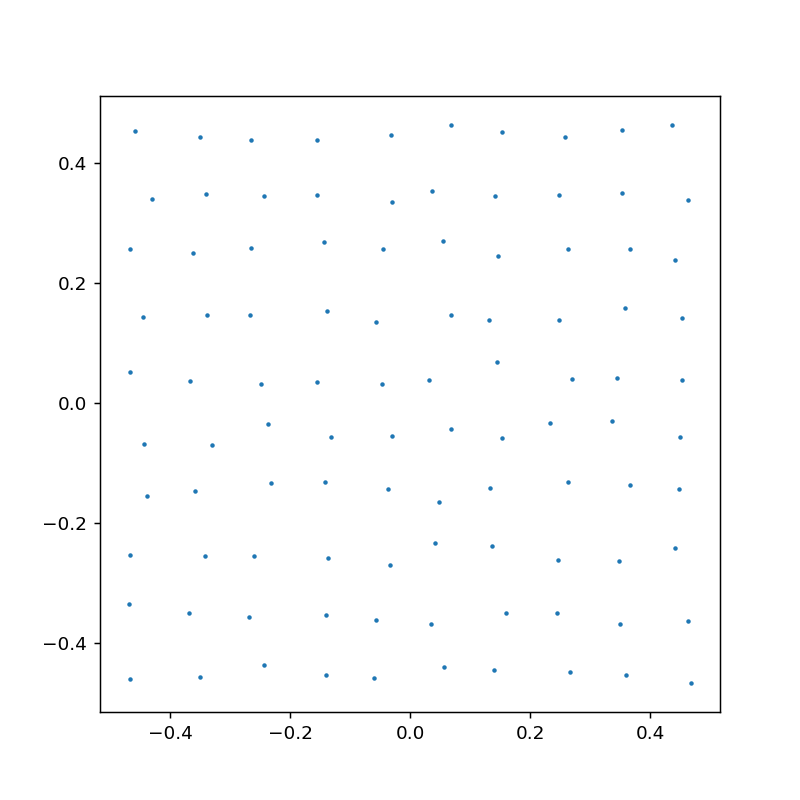

In [24]:
""" This cell creates a grid of units that make reciprocal connections to a kWTA unit. """
topo = topology()

# Create network
net_params = {'min_delay' : 0.1, 
              'min_buff_size' : 5 } # parameter dictionary for the network
net = network(net_params)

# Create group of units
unit_pars = {'init_val' : 0.5, 
             'slope' : 10.,
             'thresh' : 1.,
             'tau' : 0.01,
             'type' : unit_types.sigmoidal } 
geom = {'shape':'sheet', 
        'extent':[1.,1.], 
        'center':[0.,0.], 
        'arrangement':'grid', 
        'rows':10, 
        'columns':10, 
        'jitter' : 0.02 }
units = topo.create_group(net, geom, unit_pars)

xcoords = [ u.coordinates[0] for u in net.units ]
ycoords = [ u.coordinates[1] for u in net.units ]

# Create a kWTA unit
kwta_pars = {'init_val' : 0.1, 
             'k' : 2,
             'des_act' : 0.5,
             'type' : unit_types.kwta }
kwta = net.create(1, kwta_pars)

# Create some input units
n_inp = 4 # number of input units
inp_pars = {'type' : unit_types.source,
            'init_val' : 0.,
            'function' : lambda x: None }
inp = net.create(n_inp, inp_pars)

# Connect the group with the kWTA unit
k2u_conn_spec = {'rule' : 'all_to_all', 
                 'delay' : net_params['min_delay'] }
k2u_syn_spec = {'type' : synapse_types.static,
                'init_w' : -1. }
net.connect(units, kwta, k2u_conn_spec, k2u_syn_spec)
net.connect(kwta, units, k2u_conn_spec, k2u_syn_spec)

# Connect the inputs to the units
i2u_conn_spec = {'rule' : 'all_to_all',
                 'delay' : net_params['min_delay'] }
i2u_syn_spec = {'type' : synapse_types.static,
                'init_w' : {'distribution' : 'equal_norm', 'norm' : 1.3} }
net.connect(inp, units, i2u_conn_spec, i2u_syn_spec)

#figg = plt.figure(figsize=(6,6))
#plt.scatter(xcoords, ycoords, s=2.)
#plt.show()

In [12]:
""" This cell runs a simulation. """
# This function creates a function implementing a localized sinusoidal bump
def make_sin_pulse(t_init, t_end, per, amp): 
    return lambda t : amp * ( np.sqrt( 0.5 * 
                     (1. + np.sin( np.pi*( 2.*(t - t_init)/per - 0.5 ) ) ) ) ) if (t_init < t and t < t_end) else 0.

# This function returns an input vector. Different distributions can be implemented with this.
def input_vector():
    # right now it's just random vectors with unit norm
    vec = np.random.uniform(0., 1., n_inp)
    return  vec / np.linalg.norm(vec)

n_pres = 5 # number of input presentations
sim_time = 0. # amount of time simulated so far
pres_time = 5. # time required by an individual input presentation
all_times = []
all_activs = []
for pres in range(n_pres):
    print('Starting presentation ' + str(pres))
    t = net.sim_time
    inp_vec = input_vector()
    for i in inp:
        net.units[i].set_function(make_sin_pulse(t, t+pres_time, pres_time, inp_vec[i-inp[0]]))
        
    times, activs, plants = net.run(pres_time)
    
    all_times.append(times)
    all_activs.append(activs)

all_times = np.concatenate(all_times)
all_activs = np.concatenate(all_activs, axis=1)

Starting presentation 0
Starting presentation 1
Starting presentation 2
Starting presentation 3
Starting presentation 4


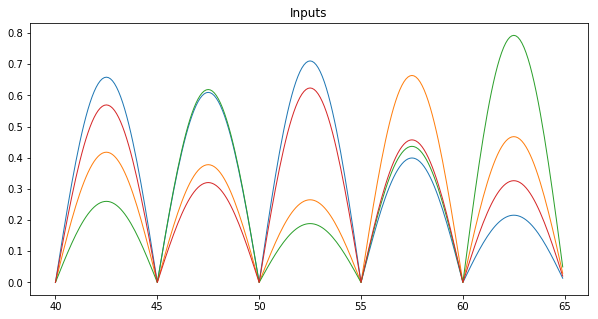

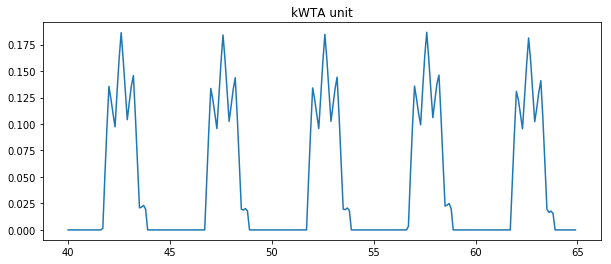

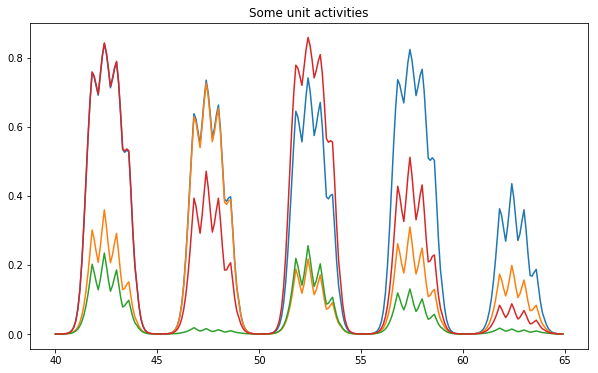

In [13]:
# Plots
%matplotlib inline
inp_fig = plt.figure(figsize=(10,5))
inputs = np.transpose([all_activs[i] for i in inp])
plt.plot(all_times, inputs, linewidth=1)
plt.title('Inputs')

inh_fig = plt.figure(figsize=(10,4))
plt.plot(all_times, all_activs[kwta[0]])
plt.title('kWTA unit')

unit_fig = plt.figure(figsize=(10,6))
some_acts = np.transpose(all_activs[[units[i] for i in [0,1,-1,-2]]])
plt.plot(all_times, some_acts)
plt.title('Some unit activities')

plt.show()

<IPython.core.display.Javascript object>


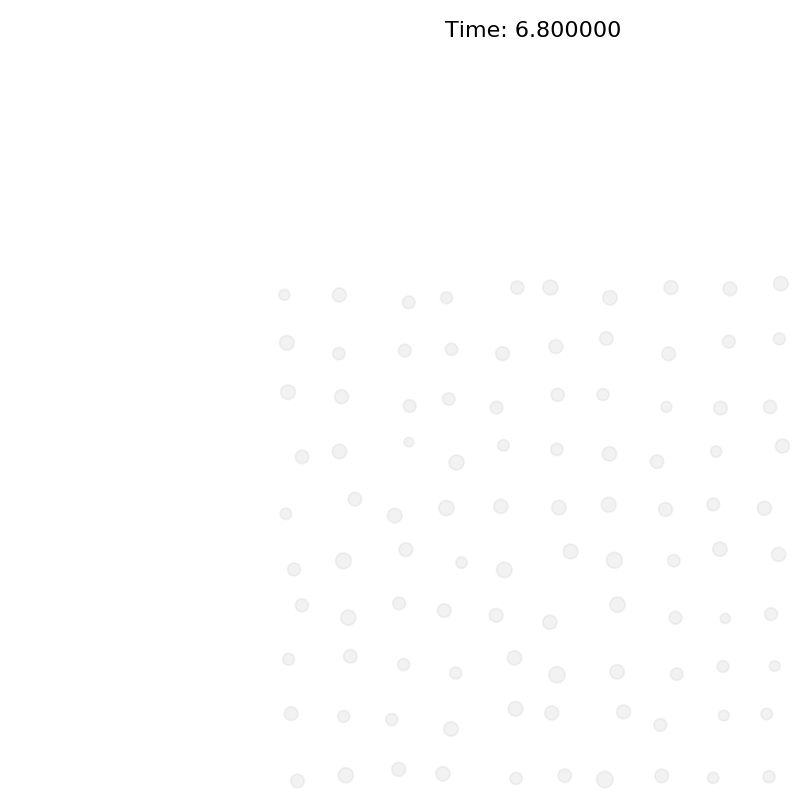

In [7]:
""" An animation to visualize the activity of the units. """
%matplotlib notebook 
# The 'notebook' backend is compatible with FuncAnimation

unit_fig = plt.figure(figsize=(8,8))
ax = unit_fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(-1, 1), ax.set_xticks([])
ax.set_ylim(-1, 1), ax.set_yticks([])
scat = ax.scatter(xcoords, ycoords, s=20.*all_activs[units,0])

def color_fun(activ):
    # given the units activity, maps into a color. activ may be an array.
    activ = 0.1 + activ*np.maximum(np.sign(activ - 0.8), 0.)
    return np.outer(activ, np.array([0., .5, 1., .5]))

n_data = len(all_activs[0])
def update(frame):
    # Each frame advances one simulation step (min_delay time units)
    idx = frame%n_data
    cur_time = net.min_delay*idx
    scat.set_sizes(300.*all_activs[units,idx])
    scat.set_color(color_fun(all_activs[units,idx]))
    unit_fig.suptitle('Time: ' + '{:f}'.format(cur_time))

animation = FuncAnimation(unit_fig, update, interval=100)
plt.show()    